In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [ ]:
!ls

drive  sample_data


In [ ]:
pwd


'/content'

In [ ]:
!pip install -q keras

In [ ]:
import keras
data_path = '/content/drive/My Drive/Colab Notebooks/data/isf2020_load_solar_data_20200326_T2_final.csv'

In [ ]:
import pandas as pd
# df = pd.read_csv(data_path, index_col='dattim')
df = pd.read_csv(data_path)
df.head(1)

,dttm,load,t0_p1,t1_p1,t2_p1,t3_p1,t0_p2,t1_p2,t2_p2,t3_p2,t0_p3,t1_p3,t2_p3,t3_p3,trend,weekdayhour11,weekdayhour12,weekdayhour13,weekdayhour14,weekdayhour15,weekdayhour16,weekdayhour17,weekdayhour18,weekdayhour19,weekdayhour110,weekdayhour111,weekdayhour112,weekdayhour113,weekdayhour114,weekdayhour115,weekdayhour116,weekdayhour117,weekdayhour118,weekdayhour119,weekdayhour120,weekdayhour121,weekdayhour122,weekdayhour123,weekdayhour124,weekdayhour21,...,t2_p2hour9,t2_p2hour10,t2_p2hour11,t2_p2hour12,t2_p2hour13,t2_p2hour14,t2_p2hour15,t2_p2hour16,t2_p2hour17,t2_p2hour18,t2_p2hour19,t2_p2hour20,t2_p2hour21,t2_p2hour22,t2_p2hour23,t2_p2hour24,t2_p3hour1,t2_p3hour2,t2_p3hour3,t2_p3hour4,t2_p3hour5,t2_p3hour6,t2_p3hour7,t2_p3hour8,t2_p3hour9,t2_p3hour10,t2_p3hour11,t2_p3hour12,t2_p3hour13,t2_p3hour14,t2_p3hour15,t2_p3hour16,t2_p3hour17,t2_p3hour18,t2_p3hour19,t2_p3hour20,t2_p3hour21,t2_p3hour22,t2_p3hour23,t2_p3hour24
0,06JAN2019:01:00:00,404.75,51.0,NaN,NaN,NaN,2601.0,NaN,NaN,NaN,132651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.tail(1)

,dttm,load,t0_p1,t1_p1,t2_p1,t3_p1,t0_p2,t1_p2,t2_p2,t3_p2,t0_p3,t1_p3,t2_p3,t3_p3,trend,weekdayhour11,weekdayhour12,weekdayhour13,weekdayhour14,weekdayhour15,weekdayhour16,weekdayhour17,weekdayhour18,weekdayhour19,weekdayhour110,weekdayhour111,weekdayhour112,weekdayhour113,weekdayhour114,weekdayhour115,weekdayhour116,weekdayhour117,weekdayhour118,weekdayhour119,weekdayhour120,weekdayhour121,weekdayhour122,weekdayhour123,weekdayhour124,weekdayhour21,...,t2_p2hour9,t2_p2hour10,t2_p2hour11,t2_p2hour12,t2_p2hour13,t2_p2hour14,t2_p2hour15,t2_p2hour16,t2_p2hour17,t2_p2hour18,t2_p2hour19,t2_p2hour20,t2_p2hour21,t2_p2hour22,t2_p2hour23,t2_p2hour24,t2_p3hour1,t2_p3hour2,t2_p3hour3,t2_p3hour4,t2_p3hour5,t2_p3hour6,t2_p3hour7,t2_p3hour8,t2_p3hour9,t2_p3hour10,t2_p3hour11,t2_p3hour12,t2_p3hour13,t2_p3hour14,t2_p3hour15,t2_p3hour16,t2_p3hour17,t2_p3hour18,t2_p3hour19,t2_p3hour20,t2_p3hour21,t2_p3hour22,t2_p3hour23,t2_p3hour24
9551,08FEB2020:00:00:00,409.5,38.5,39.5,40.5,42.5,1482.25,1560.25,1640.25,1806.25,57066.625,61629.875,66430.125,76765.625,9552.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1640.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66430.125


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import csv
time_step = []
load = []

with open( data_path) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    load.append(float(row[1]))
    time_step.append(row[0])

In [ ]:
import numpy as np
series = np.array(load)
time = np.array(time_step)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

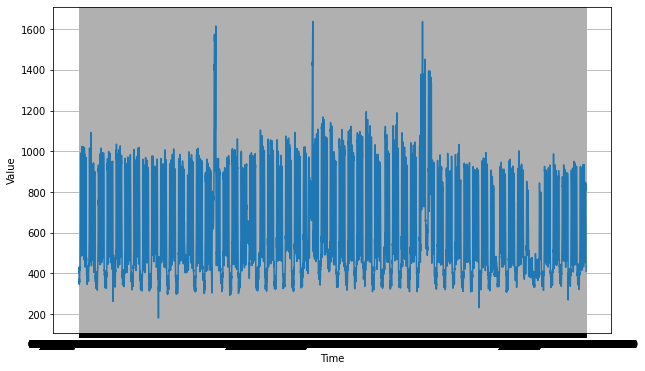

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 9384 # 06Jan2019:01 - 01Feb2020:00
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:split_time + 168] # 01Feb2020:01 - 08Feb2020:00
x_valid = series[split_time:split_time + 168]

window_size = 168
batch_size = 100
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 168
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mape", "accuracy"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(9384,)
Epoch 1/100
93/93 [==============================] - 2s 20ms/step - loss: 579.6228 - mae: 580.1228 - mape: 93.5569 - accuracy: 0.0000e+00
Epoch 2/100
93/93 [==============================] - 2s 21ms/step - loss: 538.1094 - mae: 538.6096 - mape: 85.6374 - accuracy: 0.0000e+00
Epoch 3/100
93/93 [==============================] - 2s 21ms/step - loss: 491.3219 - mae: 491.8218 - mape: 76.9609 - accuracy: 0.0000e+00
Epoch 4/100
93/93 [==============================] - 2s 21ms/step - loss: 458.1628 - mae: 458.6628 - mape: 70.7358 - accuracy: 0.0000e+00
Epoch 5/100
93/93 [==============================] - 2s 22ms/step - loss: 430.6454 - mae: 431.1453 - mape: 65.5936 - accuracy: 0.0000e+00
Epoch 6/100
93/93 [==============================] - 2s 21ms/step - loss: 402.8280 - mae: 403.3280 - mape: 60.4585 - accuracy: 0.0000e+00
Epoch 7/100
93/93 [==============================] - 2s 21ms/step - lo

(1e-08, 0.0001, 0.0, 60.0)

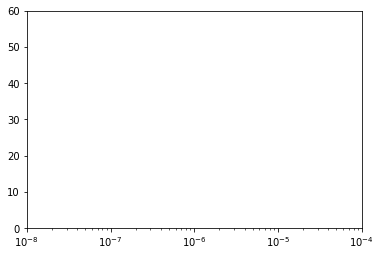

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
# rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast.shape

(9385, 168, 1)

In [ ]:
rnn_forecastx = rnn_forecast[split_time - window_size:split_time, -1, 0]

In [ ]:
rnn_forecastx.shape

(168,)

In [ ]:
split_time

9384

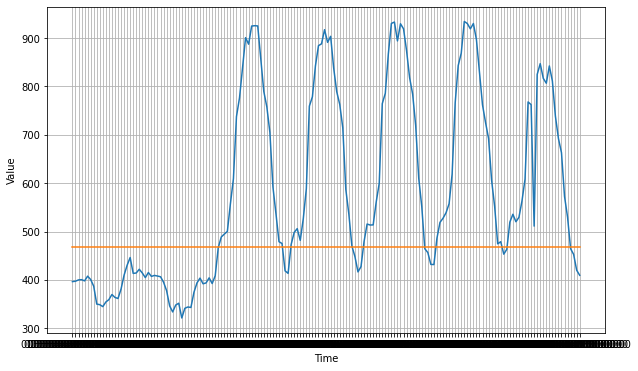

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecastx)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecastx).numpy()

170.651

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=672, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mape", "accuracy"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
88/88 [==============================] - 5s 59ms/step - loss: 286.4267 - mae: 286.9262 - mape: 44.4280 - accuracy: 0.0000e+00
Epoch 2/100
88/88 [==============================] - 5s 59ms/step - loss: 187.2658 - mae: 187.7651 - mape: 28.6485 - accuracy: 0.0000e+00
Epoch 3/100
88/88 [==============================] - 5s 59ms/step - loss: 165.8048 - mae: 166.3039 - mape: 25.8108 - accuracy: 0.0000e+00
Epoch 4/100
88/88 [==============================] - 5s 58ms/step - loss: 128.5250 - mae: 129.0240 - mape: 20.6761 - accuracy: 0.0000e+00
Epoch 5/100
88/88 [==============================] - 5s 59ms/step - loss: 85.9688 - mae: 86.4673 - mape: 14.1357 - accuracy: 0.0000e+00
Epoch 6/100
88/88 [==============================] - 5s 59ms/step - loss: 76.1976 - mae: 76.6957 - mape: 12.4641 - accuracy: 0.0000e+00
Epoch 7/100
88/88 [==============================] - 5s 59ms/step - loss: 74.6952 - mae: 75.1932 - mape: 12.1248 - accuracy: 0.0000e+00
Epoch 8/100
88/88 [=====================

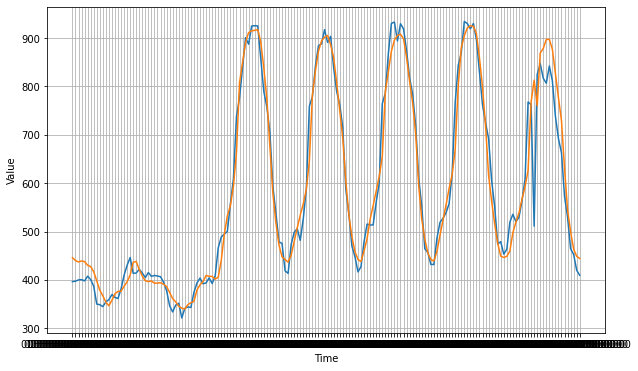

In [ ]:
rnn_forecast2 = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecastx2 = rnn_forecast2[split_time - window_size:split_time, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecastx2)


In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecastx2).numpy()

26.557735